In [2]:
import sys
import time
import logging
import pandas as pd
import numpy as np
import pulp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Import customer data

In [3]:
df_cust = pd.read_csv("./data/external/customers.csv")
df_cust["customer_id"] = df_cust["customer_id"].map(str)
df_cust.head()

,customer_id,age_cat,freq_cat
0,1,age20~34,freq2
1,2,age35~49,freq0
2,3,age35~49,freq0
3,4,age~19,freq0
4,5,age35~49,freq0


'freq_cat': How many purchases were there last year?
- 'freq0': None
- 'freq1': Once
- 'freq2': Twice
- 'freq3~': More than three times

In [4]:
df_cust.shape

(5000, 3)

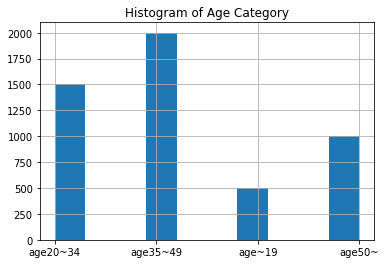

In [5]:
df_cust["age_cat"].hist()
plt.title("Histogram of Age Category")
plt.show()

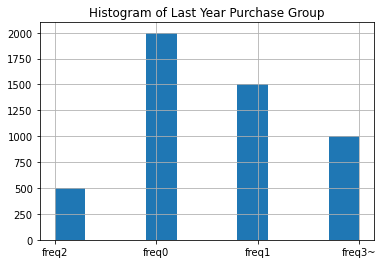

In [6]:
df_cust["freq_cat"].hist()
plt.title("Histogram of Last Year Purchase Group")
plt.show()

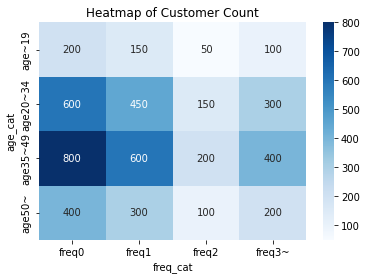

In [7]:
df_cust_pivot = pd.pivot_table(data=df_cust, values='customer_id', columns='freq_cat',
                               index='age_cat', aggfunc='count')\
                  .reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
sns.heatmap(df_cust_pivot, annot=True, fmt='d', cmap='Blues')
plt.title("Heatmap of Customer Count")
plt.show()

# Import conversion probability data

In [8]:
df_prob = pd.read_csv("./data/external/visit_probability.csv")
df_prob["segment_id"] = df_prob["segment_id"].map(str)
df_prob

,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,age~19,freq0,1,0.07,0.12,0.29
1,age~19,freq1,2,0.21,0.30,0.58
2,age~19,freq2,3,0.28,0.39,0.74
3,age~19,freq3~,4,0.35,0.45,0.77
4,age20~34,freq0,5,0.11,0.17,0.37
5,age20~34,freq1,6,0.32,0.43,0.72
6,age20~34,freq2,7,0.42,0.55,0.93
7,age20~34,freq3~,8,0.52,0.63,0.94
8,age35~49,freq0,9,0.08,0.14,0.33
9,age35~49,freq1,10,0.25,0.35,0.67


- 'prob_dm1': Probability of conversion when customers receive no coupon.
- 'prob_dm2': Probability of conversion when customers receive 10 USD coupon.
- 'prob_dm3': Probability of conversion when customers receive 20 USD coupon.

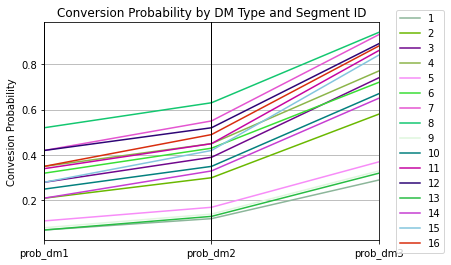

In [9]:
ax = plt.axes()
pd.plotting.parallel_coordinates(
    df_prob[["segment_id", "prob_dm1",
             "prob_dm2", "prob_dm3"]],
    class_column="segment_id")
ax.legend(
    loc="center left", 
    bbox_to_anchor=[1.05, 0.5],
    borderaxespad=0)
ax.set_ylabel("Convesion Probability")
plt.title("Conversion Probability by DM Type and Segment ID")
plt.show()

# Append probability data to customer data

In [10]:
ls_dm = [c.split("_")[-1] for c in df_prob.columns if "prob_dm" in c]

df_prob_long = df_prob\
    .rename(columns=dict(zip(["prob_" + dm for dm in ls_dm], ls_dm)))\
    .melt(id_vars=['segment_id'], value_vars=ls_dm,
          var_name='dm', value_name='prob')

df_cust_prob = df_cust.merge(df_prob, on=["age_cat", "freq_cat"])
df_cust_prob.head()

,customer_id,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,1,age20~34,freq2,7,0.42,0.55,0.93
1,199,age20~34,freq2,7,0.42,0.55,0.93
2,200,age20~34,freq2,7,0.42,0.55,0.93
3,255,age20~34,freq2,7,0.42,0.55,0.93
4,269,age20~34,freq2,7,0.42,0.55,0.93


# Optimization using PuLP

In [49]:
# Create necessary lists.
ls_cust = [c for c in df_cust["customer_id"].unique()]
ls_age_cat = [c for c in df_prob["age_cat"].unique()]
ls_freq_cat = [c for c in df_prob["freq_cat"].unique()]
ls_segment_id = [s for s in df_prob["segment_id"].unique()]
ls_dm_notdm1 = [dm for dm in ls_dm if dm != "dm1"]

In [50]:
# Create necessary dictionaries.
dict_segment_dm_prob = df_prob_long.set_index(
    ['segment_id','dm'])['prob'].to_dict()
dict_segment_count = df_cust_prob.groupby(
    ["segment_id"])["customer_id"].count().to_dict()

In [51]:
# Create variables to hold exogenous variables.
dict_dm_cost = {"dm1": 0, "dm2": 10, "dm3": 20}
max_budget = 10000

In [52]:
# Define optimization problem.
prob = pulp.LpProblem(name="CouponProblem", sense=pulp.LpMaximize)

In [53]:
# Set decision variables
x_sd = {}
for s in ls_segment_id:
    for d in ls_dm:
        x_sd[s, d] = pulp.LpVariable(
            name=f"x({s}, {d})", lowBound=0, upBound=1,
            cat="Continuous")

In [54]:
# Objective: maximize the incremental conversion
prob += pulp.lpSum(
    (dict_segment_dm_prob[s, d] - dict_segment_dm_prob[s, "dm1"]) \
    * x_sd[s, d] * dict_segment_count[s]
    for s in ls_segment_id
    for d in ls_dm_notdm1)

In [55]:
# Constraint: Every customer receives one type of direct mail.
for s in ls_segment_id:
    prob += pulp.lpSum(x_sd[s, d] for d in ls_dm) == 1

In [56]:
# Constraint: Expectation of total coupon value is $ 10K or less.
prob += pulp.lpSum(
    x_sd[s, d] * dict_dm_cost.get(d, 0) \
    * dict_segment_dm_prob[s, d] * dict_segment_count[s]
    for s in ls_segment_id
    for d in ls_dm_notdm1) <= max_budget

In [57]:
# Constraint: Each type of direct mail is sent to more than or
# equal to 10% of customers of each segment.
for s in ls_segment_id:
    for d in ls_dm:
        prob += x_sd[s, d] >= 0.1

In [58]:
# Solve optimization
time_start = time.time()
status = prob.solve()
print(f"status: {pulp.LpStatus[status]}")
time_stop = time.time()
print(f"Obj Value: {pulp.value(prob.objective):.4}")
print(f"Compute Time: {(time_stop - time_start):.3}(s)")

status: Optimal
Obj Value: 326.1
Compute Time: 0.339(s)


In [59]:
# Store output to pd.DataFrame
df_send_dm = pd.DataFrame([[x_sd[s, d].value() for d in ls_dm]
                           for s in ls_segment_id],
                          columns=["send_prob_" + dm for dm in ls_dm])
df_seg_send_prob = pd.concat([
    df_prob[['segment_id', 'age_cat', 'freq_cat']], df_send_dm],
    axis=1)
df_seg_send_prob['num_cust'] = df_seg_send_prob['segment_id']\
                               .apply(lambda x: dict_segment_count[x])
for dm in ls_dm:
    df_seg_send_prob["send_num_" + dm] = \
        df_seg_send_prob["send_prob_" + dm] * \
        df_seg_send_prob['num_cust']
    
df_seg_send_prob

,segment_id,age_cat,freq_cat,send_prob_dm1,send_prob_dm2,send_prob_dm3,num_cust,send_num_dm1,send_num_dm2,send_num_dm3
0,1,age~19,freq0,0.1,0.800000,0.100000,200,20.0,160.000000,20.000000
1,2,age~19,freq1,0.8,0.100000,0.100000,150,120.0,15.000000,15.000000
2,3,age~19,freq2,0.8,0.100000,0.100000,50,40.0,5.000000,5.000000
3,4,age~19,freq3~,0.8,0.100000,0.100000,100,80.0,10.000000,10.000000
4,5,age20~34,freq0,0.8,0.100000,0.100000,600,480.0,60.000000,60.000000
5,6,age20~34,freq1,0.8,0.100000,0.100000,450,360.0,45.000000,45.000000
6,7,age20~34,freq2,0.8,0.100000,0.100000,150,120.0,15.000000,15.000000
7,8,age20~34,freq3~,0.8,0.100000,0.100000,300,240.0,30.000000,30.000000
8,9,age35~49,freq0,0.1,0.800000,0.100000,800,80.0,640.000000,80.000000
9,10,age35~49,freq1,0.8,0.100000,0.100000,600,480.0,60.000000,60.000000


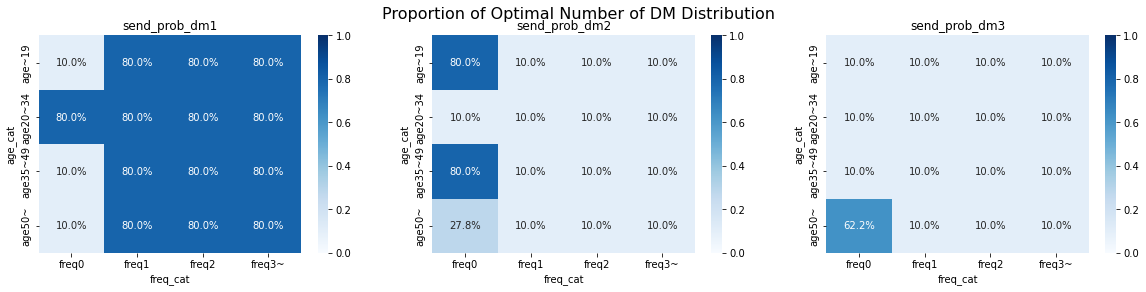

In [60]:
# Visualize results
len_ls_dm = len(ls_dm)
ls_age_cat = list(df_prob["age_cat"].unique())

ax = {}
fig, ax = \
    plt.subplots(1, len_ls_dm, figsize=(20, 4))
for i, ptn in enumerate(["send_prob_" + dm for dm in ls_dm]):
    df_seg_send_pivot = pd.pivot_table(
        data=df_seg_send_prob, values=ptn, columns="freq_cat", 
        index="age_cat", aggfunc="mean")
    df_seg_send_pivot = df_seg_send_pivot.reindex(ls_age_cat)
    sns.heatmap(
        df_seg_send_pivot, annot=True, fmt=".1%", cmap="Blues", 
        vmin=0, vmax=1, ax=ax[i])
    ax[i].set_title(f"{ptn}")
fig.suptitle("Proportion of Optimal Number of DM Distribution", fontsize=16)
plt.show()

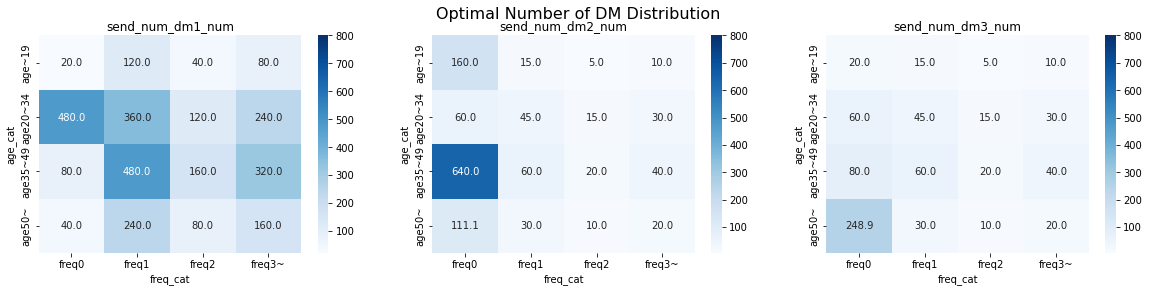

In [62]:
ax = {}
fig, ax = \
    plt.subplots(1, len_ls_dm, figsize=(20, 4))
for i, ptn in enumerate(["send_num_" + dm for dm in ls_dm]):
    df_cust_send_pivot = pd.pivot_table(
        data=df_seg_send_prob, values=ptn, columns="freq_cat",
        index="age_cat", aggfunc="sum")
    df_cust_send_pivot = df_cust_send_pivot.reindex(ls_age_cat)
    sns.heatmap(
        df_cust_send_pivot, annot=True, fmt=".1f", cmap="Blues",
        vmax=800, ax=ax[i])
    ax[i].set_title(f"{ptn}_num")
fig.suptitle("Optimal Number of DM Distribution", fontsize=16)
plt.show()